Training model without compression:
Epoch 1, Loss: 0.1640, Duration: 8.50 seconds
Test accuracy after epoch 1: 98.59%
Epoch 2, Loss: 0.0469, Duration: 9.82 seconds
Test accuracy after epoch 2: 98.82%
Epoch 3, Loss: 0.0316, Duration: 10.05 seconds
Test accuracy after epoch 3: 98.79%
Epoch 4, Loss: 0.0233, Duration: 9.86 seconds
Test accuracy after epoch 4: 99.16%
Epoch 5, Loss: 0.0167, Duration: 9.92 seconds
Test accuracy after epoch 5: 98.99%
Epoch 6, Loss: 0.0136, Duration: 10.11 seconds
Test accuracy after epoch 6: 98.93%
Epoch 7, Loss: 0.0107, Duration: 10.05 seconds
Test accuracy after epoch 7: 99.14%
Epoch 8, Loss: 0.0095, Duration: 9.79 seconds
Test accuracy after epoch 8: 98.88%
Epoch 9, Loss: 0.0071, Duration: 10.10 seconds
Test accuracy after epoch 9: 99.18%
Epoch 10, Loss: 0.0062, Duration: 10.07 seconds
Test accuracy after epoch 10: 98.43%
Epoch 11, Loss: 0.0070, Duration: 10.01 seconds
Test accuracy after epoch 11: 99.03%
Epoch 12, Loss: 0.0059, Duration: 10.09 seconds
Test

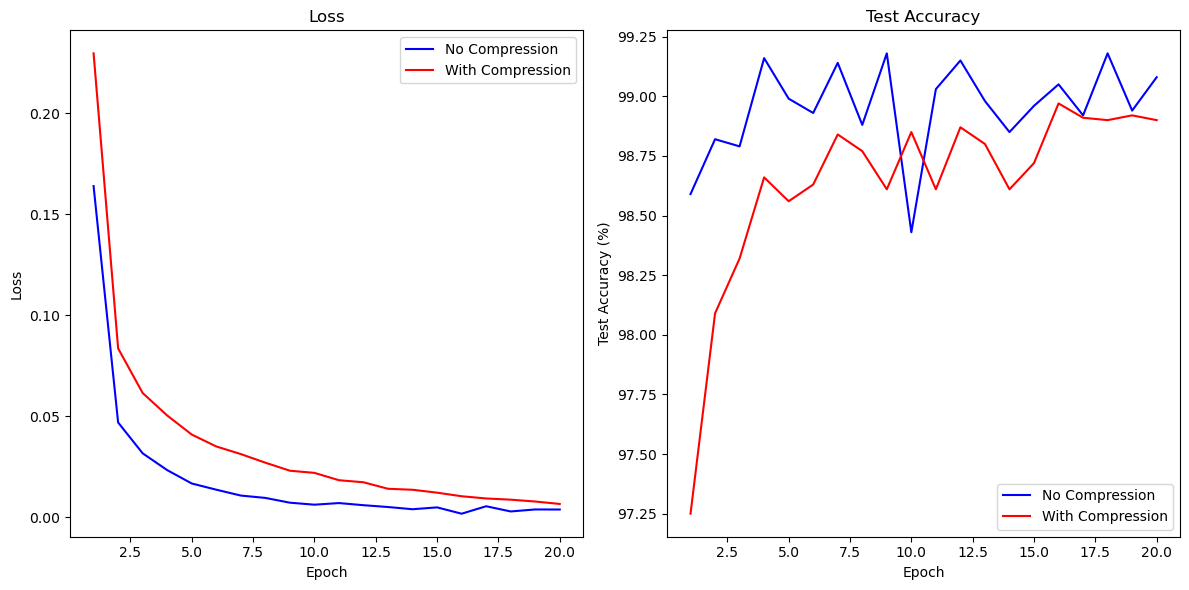

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import time
import matplotlib.pyplot as plt

# Compress weights using MiniBatch K-means with initialization from previous centroids
def compress_weights_with_mini_batch_kmeans(weight_matrix, s, batch_size=2048, init_centroids=None):
    flattened_weights = weight_matrix.flatten().reshape(-1, 1)
    if init_centroids is None:
        init_centroids = 'k-means++'
    
    kmeans = MiniBatchKMeans(n_clusters=s, batch_size=batch_size, n_init=1, random_state=0, init=init_centroids)
    kmeans.fit(flattened_weights)
    
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_.flatten()
    compressed_weights = centroids[labels].reshape(weight_matrix.shape)
    
    return torch.tensor(compressed_weights, dtype=torch.float32), kmeans.cluster_centers_

# Simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, compression=False, s=32):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.compression = compression
        self.s = s
        self.init_centroids = None  # Variable to hold initial centroids

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Test function to compute accuracy on the test set
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No gradients are computed during testing
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # Get the predicted class
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    
    accuracy = 100. * correct / total  # Calculate accuracy on the test set
    return accuracy

# Training function with compression after each step, including epoch timing
def train_with_compression(model, train_loader, optimizer, criterion, epochs=20, test_loader=None):
    model.train()
    losses = []  # To store the loss values for plotting
    test_accuracies = []  # To store test accuracies for plotting
    for epoch in range(epochs):
        start_time = time.time()  # Start timing the epoch
        epoch_loss = 0.0
        
        for data, target in train_loader:
            data, target = data.cuda(), target.cuda()
            
            # Forward and backward pass
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            
            # Update weights
            optimizer.step()

            # Compress weights after optimizer step if compression is enabled
            if model.compression:
                with torch.no_grad():
                    compressed_weights, centroids = compress_weights_with_mini_batch_kmeans(
                        model.fc1.weight.data.cpu().numpy(), model.s, init_centroids=model.init_centroids
                    )
                    model.fc1.weight.data.copy_(compressed_weights.to(data.device))
                    model.init_centroids = centroids

            # Accumulate loss
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        
        # End timing the epoch
        end_time = time.time()
        epoch_duration = end_time - start_time
        print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Duration: {epoch_duration:.2f} seconds")

        # Print accuracy at the end of each epoch
        if test_loader is not None:
            test_accuracy = test_model(model, test_loader)  # Test accuracy after each epoch
            test_accuracies.append(test_accuracy)
            print(f"Test accuracy after epoch {epoch + 1}: {test_accuracy:.2f}%")

    return losses, test_accuracies

# Training and testing function
def train_and_test(model, train_loader, test_loader, optimizer, criterion, epochs=20):
    # Train the model and get loss per epoch and test accuracies
    losses, test_accuracies = train_with_compression(model, train_loader, optimizer, criterion, epochs, test_loader)
    return losses, test_accuracies

# Main function
def main():
    # Load MNIST dataset
    transform = transforms.Compose([transforms.ToTensor()])
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform),
        batch_size=64, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform),
        batch_size=1000, shuffle=False
    )

    # Initialize and train model without compression
    print("Training model without compression:")
    model_no_compression = SimpleCNN(compression=False).cuda()
    optimizer_no_compression = optim.Adam(model_no_compression.parameters())
    criterion = nn.CrossEntropyLoss()
    losses_no_compression, test_accuracies_no_compression = train_and_test(model_no_compression, train_loader, test_loader, optimizer_no_compression, criterion)

    # Initialize and train model with post-step compression
    print("\nTraining model with post-step compression:")
    model_compression = SimpleCNN(compression=True, s=32).cuda()
    optimizer_compression = optim.Adam(model_compression.parameters())
    losses_compression, test_accuracies_compression = train_and_test(model_compression, train_loader, test_loader, optimizer_compression, criterion)

    # Plotting loss and test accuracy over epochs for both models
    epochs = range(1, 21)

    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses_no_compression, label='No Compression', color='b')
    plt.plot(epochs, losses_compression, label='With Compression', color='r')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Test Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies_no_compression, label='No Compression', color='b')
    plt.plot(epochs, test_accuracies_compression, label='With Compression', color='r')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Run the main function
if __name__ == "__main__":
    main()
